# DOR

In [1]:
import os
import subprocess

whoami = subprocess.run("whoami", stdout=subprocess.PIPE)
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/10x10kc250kr.h5ad")):
    !sh /home/jovyan/data/10x10kc250kr.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/10x80kc25kr.h5ad")):
    !sh /home/jovyan/data/10x80kc25kr.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/c1htmedium.h5ad")):
    !sh /home/jovyan/data/c1htmedium.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/c1htsmall.h5ad")):
    !sh /home/jovyan/data/c1htsmall.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/celseq2.h5ad")):
    !sh /home/jovyan/data/celseq2.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/dropseq.h5ad")):
    !sh /home/jovyan/data/dropseq.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/icell8.h5ad")):
    !sh /home/jovyan/data/icell8.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/marsseq.h5ad")):
    !sh /home/jovyan/data/marsseq.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/quartzseq2.h5ad")):
    !sh /home/jovyan/data/quartzseq2.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/gmcscrbseq.h5ad")):
    !sh /home/jovyan/data/gmcscrbseq.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/smartseq2.h5ad")):
    !sh /home/jovyan/data/smartseq2.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/singlenuclei.h5ad")):
    !sh /home/jovyan/data/singlenuclei.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/ddseq.h5ad")):
    !sh /home/jovyan/data/ddseq.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/indrop.h5ad")):
    !sh /home/jovyan/data/indrop.sh
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/10xv3.h5ad")):
    !sh /home/jovyan/data/10xv3.sh

In [2]:
from typing import NamedTuple

from grnet.anndata.preprocessing import binarize, rpm, logtransform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from tools.dor.metrics import mae, mse, horizontal_mae, horizontal_maxae
from tools.dor.models import LogisticModel, NegativeBinomial, Poisson
from tools.plot import vinswarm
from tools.preferences import kwarg_savefig

In [3]:
class Config(NamedTuple):
    export: str = "/home/jovyan/output/logistic_model"
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)

In [4]:
dsname = {
    "10x10kc250kr": "Chromium V2\n(deep)",
    "10x80kc25kr": "Chromium V2\n(shallow)",
    "singlenuclei": "Chromium V2\n(sn)",
    "10xv3": "Chromium V3",
    "c1htmedium": "C1HT-medium",
    "c1htsmall": "C1HT-small",
    "celseq2": "CEL-seq2",
    "dropseq": "Drop-seq",
    "icell8": "ICELL8",
    "marsseq": "MARS-Seq",
    "quartzseq2": "Quartz-Seq2",
    "gmcscrbseq": "gmcSCRB-seq",
    "ddseq": "ddSEQ",
    "indrop": "inDrop",
    "smartseq2": "Smart-Seq2",
}

In [5]:
bin_datasets = [
    binarize(
        sc.read_h5ad(
            f"/home/jovyan/data/{ds}.h5ad",
            as_sparse=["X"]
        ),
        normalizer=lambda X: logtransform(rpm(X), base=2)
    ) for ds in dsname
]

In [6]:
cov = pd.concat([
    ds.var.assign(
        name=[n for v in range(ds.shape[1])]
    ) for ds, n in zip(bin_datasets, dsname.values())
])

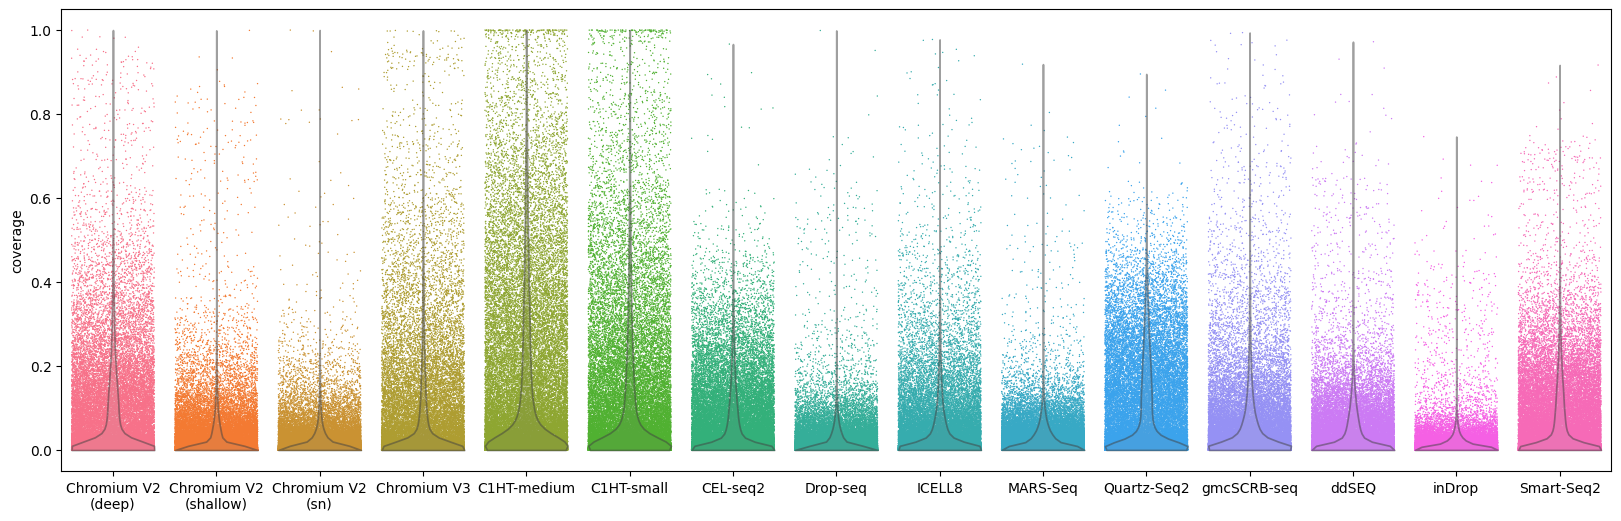

In [7]:
fig, ax = plt.subplots(figsize=(20, 6))

vinswarm(
    data=cov,
    x="name", y="coverage", hue="name",
    alpha=.5, jitter=.4, s=1, ax=ax
)

ax.set(xlabel="");

fig.savefig(f"{conf.export}/coverage.png", **kwarg_savefig)

In [8]:
meta = pd.concat([
    ds.obs.assign(
        name=[n for v in range(ds.shape[0])]
    ) for ds, n in zip(bin_datasets, dsname.values())
])

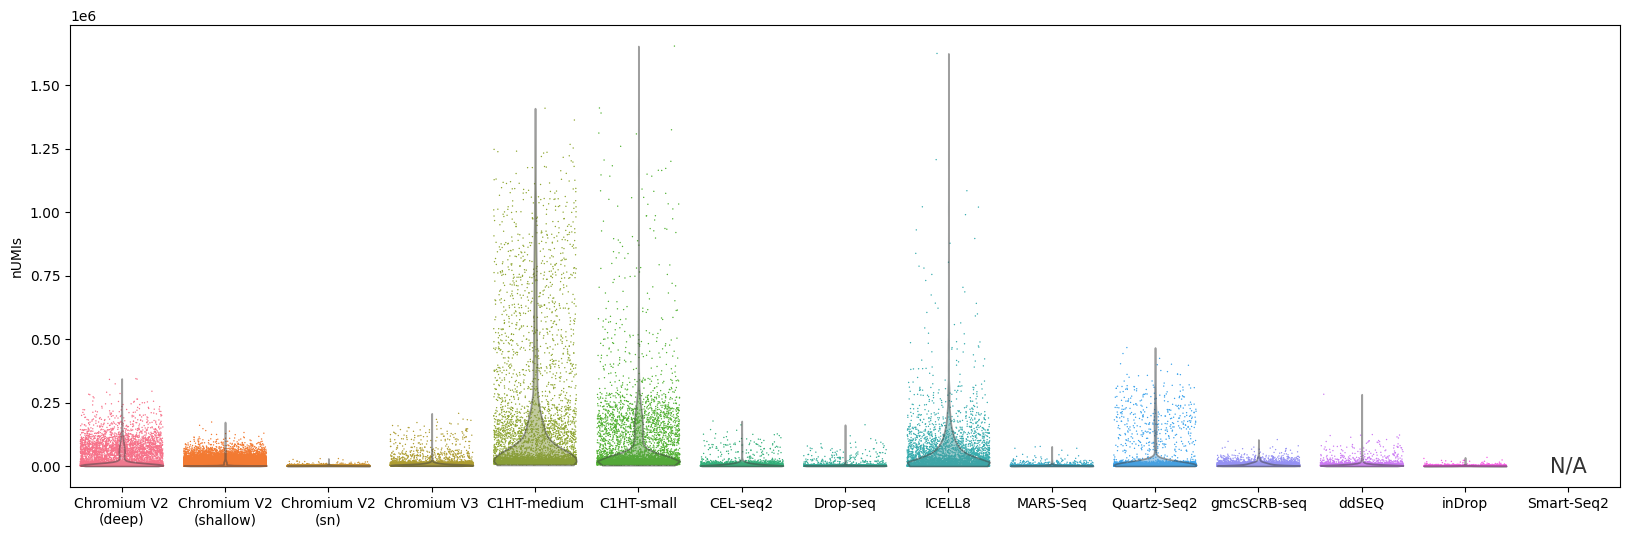

In [9]:
fig, ax = plt.subplots(figsize=(20, 6))

vinswarm(
    data=meta,
    x="name", y="nUMIs", hue="name",
    alpha=.5, jitter=.4, s=1, ax=ax
)

for i, n in enumerate(dsname.values()):
    ax.text(
        i, 0, "N/A", ha="center", va="center", size=15, c=".2"
    ) if np.isnan(meta[meta.name == n]["nUMIs"]).any() else None

ax.set(xlabel="");

fig.savefig(f"{conf.export}/umi.png", **kwarg_savefig)

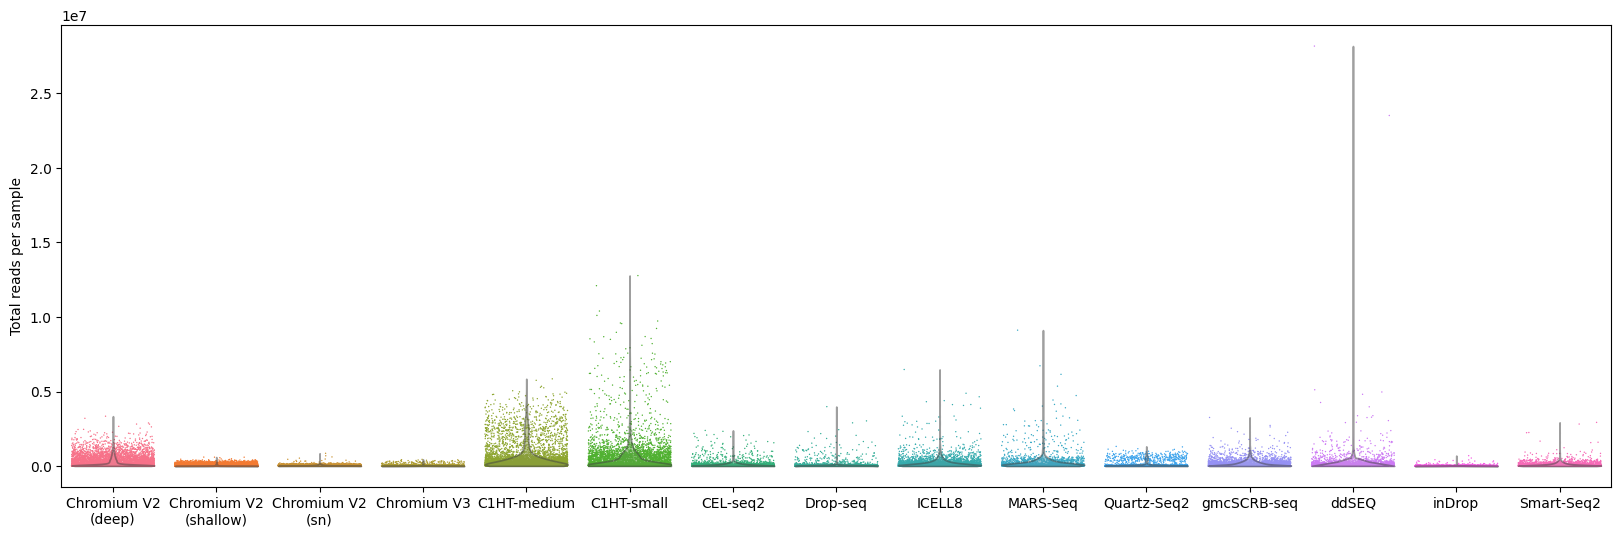

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))

vinswarm(
    data=meta,
    x="name", y="nTReads", hue="name",
    alpha=.5, jitter=.4, s=1, ax=ax
)

ax.set(xlabel="", ylabel="Total reads per sample");

fig.savefig(f"{conf.export}/total_reads.png", **kwarg_savefig)

In [11]:
datasize = pd.DataFrame({
    "name": [n.replace("\n", " ") for n in dsname.values()],
    "n_samples": [ds.shape[0] for ds in bin_datasets],
    "nTReads": [ds.obs.nTReads.sum() for ds in bin_datasets]
})

In [12]:
from adjustText import adjust_text

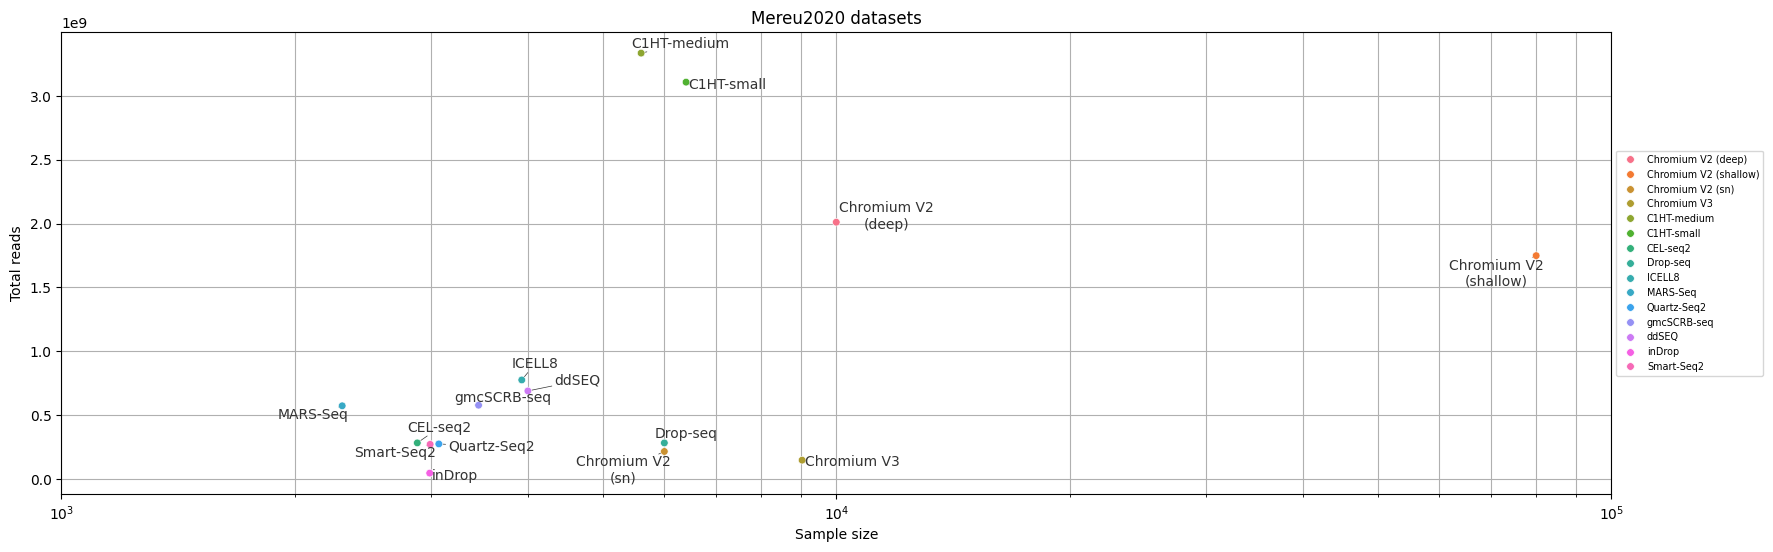

In [13]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.scatterplot(
    data=datasize,
    x="n_samples", y="nTReads",
    hue="name", s=30, zorder=2
)
ax.set_xlim(1000, 100000)
ax.set_xscale("log")
ax.grid(which="both", zorder=-5)

ax.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize="x-small")
txt = []
for i, name in enumerate(dsname.values()):
    txt += [ax.text(
        *datasize.loc[i, ["n_samples", "nTReads"]], 
        name,
        size=10, ha="center", va="center",
        c=".2"
    )]

adjust_text(txt, arrowprops=dict(arrowstyle='-', color='.2', lw=0.5))

ax.set(title="Mereu2020 datasets", xlabel="Sample size", ylabel="Total reads")

fig.savefig(f"{conf.export}/scatter.png", **kwarg_savefig)

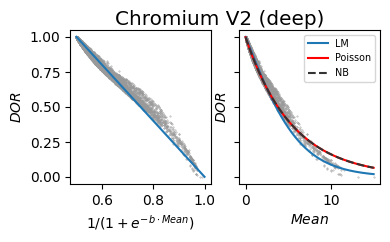

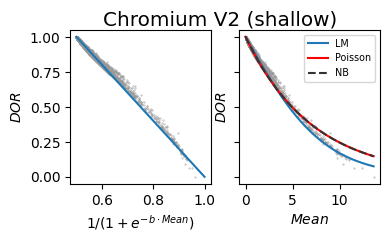

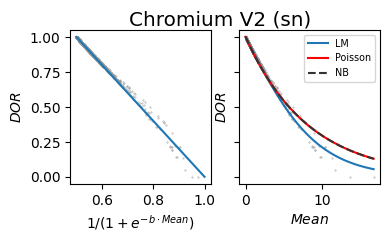

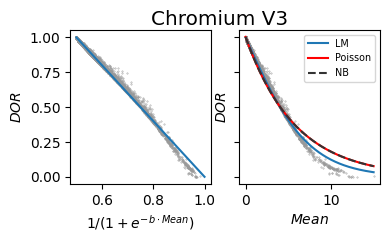

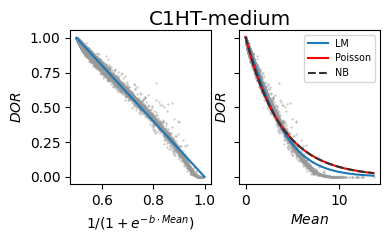

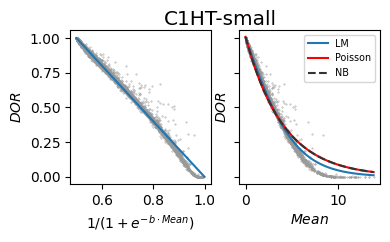

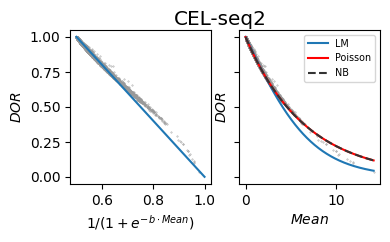

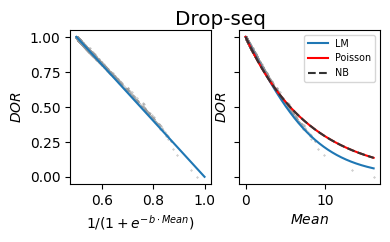

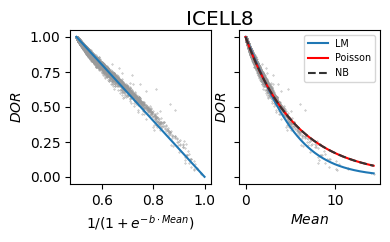

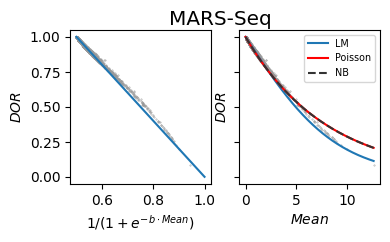

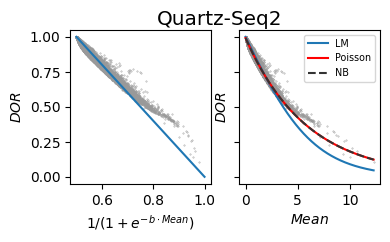

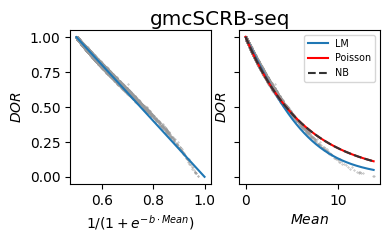

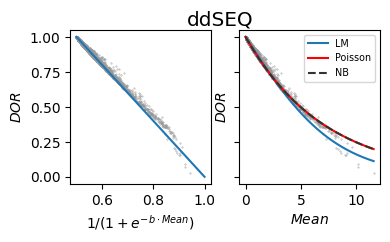

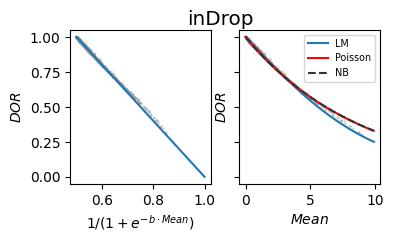

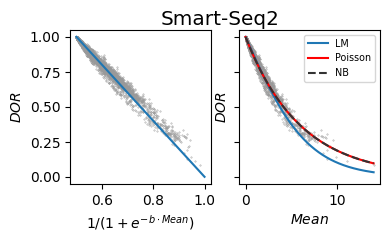

In [14]:
lms = []
pois = []
nbs = []

for ds, (k, n) in zip(bin_datasets, dsname.items()):
    
    fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharey=True)

    lm = LogisticModel()
    lm.fit(ds)
    lm.plot(ax=ax[0])
    lm.calibration_plot(ax=ax[-1])
    ax[0].set(title="")
    ax[0].get_legend().remove()
    ax[-1].set(title="", ylabel="")
    fig.suptitle(n.replace("\n", " "), fontsize="x-large")

    poi = Poisson()
    poi.fit(ds)
    poi.calibration_plot(ax=ax[-1], hide_dots=True, linecolor="r")
    
    nb = NegativeBinomial()
    nb.fit(ds)
    nb.calibration_plot(ax=ax[-1], hide_dots=True, linecolor=".2", linestyle="--")
    
    lms += [lm]
    pois += [poi]
    nbs += [nb]

    ax[-1].legend(fontsize="x-small")

    fig.savefig(f"{conf.export}/{k}_calibration_curve.png", **kwarg_savefig)

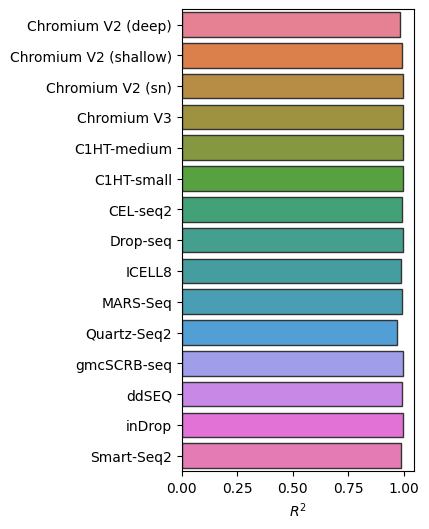

In [15]:
fig, ax = plt.subplots(figsize=(3, 6))

sns.barplot(
    data=pd.DataFrame({
        "name": [n.replace("\n", " ") for n in dsname.values()],
        "r2": [lm.r2_score for lm in lms]
    }),
    x="r2", y="name", hue="name", ax=ax,
    edgecolor=".2"
)

ax.set(ylabel="", xlabel="$R^2$");

fig.savefig(f"{conf.export}/r_squared.png", **kwarg_savefig)

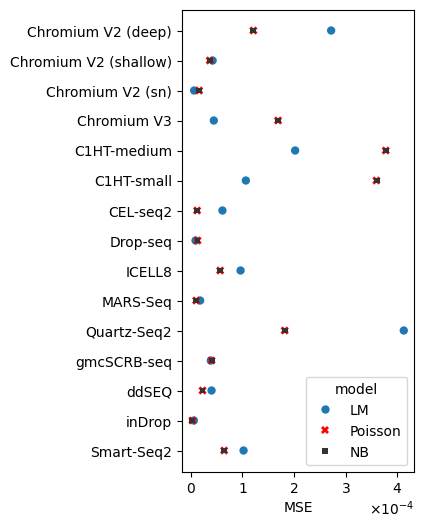

In [21]:
fig, ax = plt.subplots(figsize=(3, 6))

sns.scatterplot(
    data=pd.DataFrame({
        "name": [n.replace("\n", " ") for n in dsname.values()] * 3,
        "mse": [m.mse for m in lms + pois + nbs],
        "model": [m.name for m in lms + pois + nbs]
    }),
    x="mse", y="name", hue="model", ax=ax,
    linewidth=0, palette=["C0", "r", ".2"],
    style="model"
)

ax.ticklabel_format(
    axis="x", style="sci", scilimits=(-5, -4), useMathText=True
)

ax.set(ylabel="", xlabel="MSE")

fig.savefig(f"{conf.export}/mse.png", **kwarg_savefig)

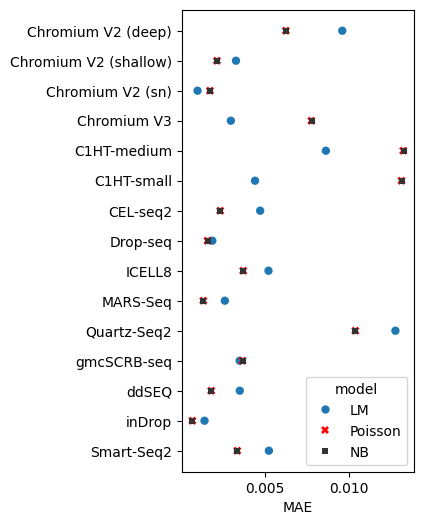

In [22]:
fig, ax = plt.subplots(figsize=(3, 6))

sns.scatterplot(
    data=pd.DataFrame({
        "name": [n.replace("\n", " ") for n in dsname.values()] * 3,
        "mae": [mae(m.y, m.f(m.x)) for m in lms + pois + nbs],
        "model": [m.name for m in lms + pois + nbs]
    }),
    x="mae", y="name", hue="model", ax=ax,
    linewidth=0, palette=["C0", "r", ".2"],
    style="model"
)

ax.set(ylabel="", xlabel="MAE")

fig.savefig(f"{conf.export}/mae.png", **kwarg_savefig)

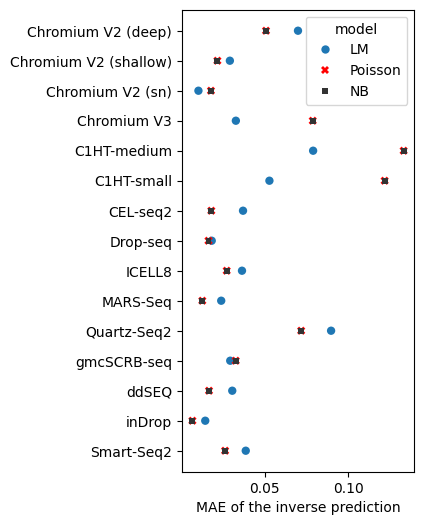

In [23]:
fig, ax = plt.subplots(figsize=(3, 6))

sns.scatterplot(
    data=pd.DataFrame({
        "name": [n.replace("\n", " ") for n in dsname.values()] * 3,
        "inverse mae": [
            horizontal_mae(m.x, m.y, m.predict_mean) for m in lms + pois + nbs
        ],
        "model": [m.name for m in lms + pois + nbs]
    }),
    x="inverse mae", y="name", hue="model", ax=ax,
    linewidth=0, palette=["C0", "r", ".2"],
    style="model"
)

ax.set(ylabel="", xlabel="MAE of the inverse prediction")

fig.savefig(f"{conf.export}/inv_mae.png", **kwarg_savefig)

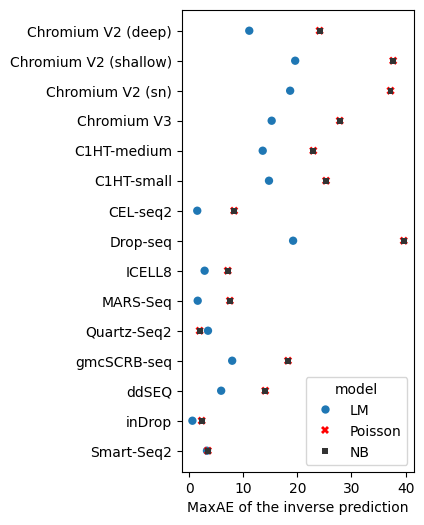

In [24]:
fig, ax = plt.subplots(figsize=(3, 6))

sns.scatterplot(
    data=pd.DataFrame({
        "name": [n.replace("\n", " ") for n in dsname.values()] * 3,
        "inverse maxae": [
            horizontal_maxae(m.x, m.y, m.predict_mean) for m in lms + pois + nbs
        ],
        "model": [m.name for m in lms + pois + nbs]
    }),
    x="inverse maxae", y="name", hue="model", ax=ax,
    linewidth=0, palette=["C0", "r", ".2"],
    style="model"
)

ax.set(ylabel="", xlabel="MaxAE of the inverse prediction")

fig.savefig(f"{conf.export}/inv_maxae.png", **kwarg_savefig)